# E4. 작사가 인공지능 만들기_실습

## 프로젝트 배경
- [초거대 AI에 투자하는 IT 기업들](http://theviewers.co.kr/View.aspx?No=1978735)
- AI 개발의 최종 목표는 인간의 학습 능력과 언어 구사 능력을 최대한 비슷하게 만들어내는 것
- 초거대 AI는 슈퍼 컴퓨터를 기반으로 스스로 학습하는 능력을 높인 더 나아간 AI 의미. 인간의 뇌와 최대한 비슷하게 구동하며 명령을 듣는 수동자 역할이 아닌 능동자의 역할을 할 가능성 높아짐
- 초거대 AI의 핵심 기술은 '언어모델'. 인간이 구사하는 언어를 빠르게 이해하고 이를 재해석하는 등 원활한 학습을 위해 언어모델이 필수적으로 뒷받침돼야 함
- 해외에서는 작년에 일론 머스크 테슬라 CEO 등이 모여 설립한 미국의 오픈AI가 지난해 초거대 AI 언어 모델 'GPT-3'를 공개
- '하이퍼 글로바'는 이를 뛰어넘는 규모로 GPT-3보다 한국어 데이터를 6500배 이상 학습, 한국어에 최적화한 모델을 개발하겠다는 목표 가지고 있음

## 프로젝트 개요
- 인공지능이 글을 이해하는 방식은 어떤 문법적인 원리를 통해서가 아닌, **수많은 글을 읽게 함으로써** 통계적으로 그 사실을 알게 하는 것
- 그런 이유에서 **많은 데이터가 곧 좋은 결과**를 만들어냄
- 이 방식을 가장 잘 처리하는 인공지능 중 하나가 **순환신경망(RNN)**
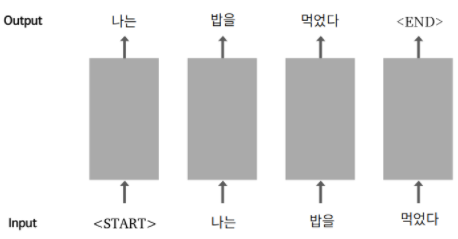
- 'start'라는 특수한 토큰을 맨 앞에 추가해 줌으로써 인공지능에게 '문장을 생성'하라는 신호를 주는 것
- start를 입력으로 받은 순환신경망은 다음 단어로 '나는'을 생성하고, **생성한 단어를 다시 입력으로 사용**
- 순차적으로 '밥을 먹었다'까지 생성하고 나면, 인공지능은 다 만들었다는 신호로 'end'라는 특수한 토큰 생성
- n-1개의 단어 시퀀스 w1, ..., wn-1가 주어졌을 때, n번째 단어 wn으로 무엇이 올지를 예측하는 확률 모델인 **언어 모델(Language Model)** 만드는 것


## 활용 데이터셋
- 49개의 영문 가사 파일. 총 187,077개의 문장이 포함되어 있음

## Step 1. 데이터 다운로드

- 데이터 위치: ~/aiffel/lyricist/data/lyrics

## Step 2. 데이터 읽어오기

- glob 모듈 사용하면 파일 읽어오는 작업 사기 아주 용이
- glob를 활용하여 모든 txt 파일 읽어온 후, raw_corpus 리스트에 문장 단위로 저장

In [4]:
import glob
import os

txt_file_path = os.getenv('HOME') + '/aiffel/lyricist/data/lyrics/*'

txt_list = glob.glob(txt_file_path)

raw_corpus = []

# 여러개의 txt 파일을 모두 읽어서 raw_corpus에 담기
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)
        
print("총 파일 수:", len(txt_list))        
print("데이터 크기: ", len(raw_corpus))
print("Examples:\n", raw_corpus[:3])

총 파일 수: 49
데이터 크기:  187088
Examples:
 ['At first I was afraid', 'I was petrified', 'I kept thinking I could never live without you']


## Step 3. 데이터 정제

- **문장 생성에 적합한 모양새로 데이터 정제**
- preprocess_sentence() 함수를 통해 데이터 정제
- 지나치게 긴 문장은 다른 데이터들이 과도한 Padding을 갖게 하므로 제거
- 너무 긴 문장은 노래 가사 작사하기에 어울리지 않을 수도 있음
- 문장을 **토큰화 했을 때 토큰의 개수가 15개를 넘어가는 문장을 학습 데이터에서 제외하기**를 권장

In [3]:
import re

In [4]:
# 입력된 문장을
def preprocess_sentence(sentence):
    # 1. 소문자로 바꾸고, 양쪽 공백 지우기
    sentence = sentence.lower().strip()
    # 2. 특수문자 양쪽에 공백을 넣고
    sentence = re.sub(r"([?.!,¿])", r" \1", sentence)
    # 3. 여러 개의 공백은 하나의 공백으로 바꾸기
    sentence = re.sub(r'[" "] +'," ", sentence)
    # 4. a-zA-Z?.!,¿가 아닌 문자를 하나의 공백으로 바꾸기
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence)
    # 5. 다시 양쪽 공백 지우기
    sentence = sentence.strip()
    # 6. 문장 시작에는 <start>, 끝에는 <end> 추가
    sentence = '<start> ' + sentence + ' <end>'
    
    return sentence

# 이 문장에 어떻게 필터링되는지 확인
print(preprocess_sentence("This @_is ;;;sample       sentence."))

<start> this is sample sentence . <end>


In [4]:
# 여기에 정제된 문장 모을것
corpus = []

for sentence in raw_corpus:
    # 길이가 0인 문장은 건너뛰기
    if len(sentence) == 0: continue
        
    # 정제를 하고 담기
    preprocessed_sentence = preprocess_sentence(sentence)
    corpus.append(preprocessed_sentence)
    
# 정제된 결과를 10개만 확인
corpus[:10]

['<start> at first i was afraid <end>',
 '<start> i was petrified <end>',
 '<start> i kept thinking i could never live without you <end>',
 '<start> by my side but then i spent so many nights <end>',
 '<start> just thinking how you ve done me wrong <end>',
 '<start> i grew strong <end>',
 '<start> i learned how to get along and so you re back <end>',
 '<start> from outer space <end>',
 '<start> i just walked in to find you <end>',
 '<start> here without that look upon your face i should have changed that fucking lock <end>']

In [5]:
# 토큰화할 때 텐서플로우의 Tokenizer와 pad_sequences 사용

# 모듈 불러오기
import tensorflow as tf
import numpy as np

def tokenize(corpus):
    # 15000 단어를 기억할 수 있는 tokenizer 만들기
    # 이미 문장을 정제했으니 filters가 필요 없음
    # 15000단어에 포함되지 못한 단어는 '<unk>'로 바꾸기
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words = 15000,
        filters = ' ',
        oov_token = "<unk>"
    )
    
    # corpus를 이용해 tokenizer 내부의 단어장 완성
    tokenizer.fit_on_texts(corpus)

    # 준비한 tokenizer를 이용해 corpus를 Tensor로 변환
    tensor = tokenizer.texts_to_sequences(corpus)
    
     = []
    for i in tensor:
        if len(i) <= 15:
            a.append(i)
        tensor = a
        
    
    # 입력 데이터의 시퀀스 길이를 일정하게 맞춤
    # 만약 시퀀스가 짧다면 문장 뒤에 패딩 붙여 길이 맞추기
    # 문장 앞에 패딩을 붙여 길이를 맞추고 싶다면, padding = 'pre'를 사용
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding = 'post')
    
    print(tensor, tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

[[   2   71  241 ...    0    0    0]
 [   2    5   57 ...    0    0    0]
 [   2    5 1086 ...    0    0    0]
 ...
 [   2    8    5 ...    0    0    0]
 [   2   48   16 ...    0    0    0]
 [   2    6  181 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7f12a2fb8e90>


In [6]:
# 생성된 텐서 데이트를 3번째 행, 10번째 행까지만 출력
print(tensor[:3, :10])

[[   2   71  241    5   57  663    3    0    0    0]
 [   2    5   57 6509    3    0    0    0    0    0]
 [   2    5 1086  533    5  103   79  205  258    7]]


In [7]:
# 텐서 데이터는 모두 정수로 이루어져 있음
# tokenizer에 구축된 단어 사전의 인덱스
# 단어 사전이 어떻게 구축되었는지 확인
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])
    
    if idx >= 10: break

1 : <unk>
2 : <start>
3 : <end>
4 : ,
5 : i
6 : the
7 : you
8 : and
9 : to
10 : a


In [8]:
# 생성된 텐서를 소스와 타겟으로 분리하여 모델이 학습할 수 있게 함
# 이 과정에서도 텐서플로우가 제공하는 모듈 사용
# 텐서 출력부에서 행 뒤쪽이 0이 많이 나온 부분은 정해진 입력 시퀀스 길이보다 문장이 짧을 경우 0으로 패딩(padding) 채워 넣은 것
# 사전에는 없지만 0은 바로 패딩 문자 <pad>가 될 것

# tensor에서 마지막 토큰을 잘라내서 소스 문장 생성
# 마지막 토큰은 <end>가 아니라 <pad>일 가능성 높음
src_input = tensor[:, :-1]

# tensor에서 <start>를 잘라내서 타겟 문장 생성
tgt_input = tensor[:, 1:]

print(src_input[0])
print(tgt_input[0])

[  2  71 241   5  57 663   3   0   0   0   0   0   0   0]
[ 71 241   5  57 663   3   0   0   0   0   0   0   0   0]


## Step 4. 평가 데이터셋 분리

- 훈련 데이터와 평가 데이터 분리
- tokenize() 함수로 데이터를 Tensor로 변환한 후, sklearn 모듈의 train_test_split() 함수를 사용해 훈련 데이터와 평가 데이터를 분리
- **단어장의 크기는 12,000이상**으로 설정
- **총 데이터의 20%** 를 평가 데이터셋으로 사용

#### 데이터셋 객체 생성하기

In [9]:
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256
steps_per_epoch = len(src_input) // BATCH_SIZE

# tokenizer가 구축한 단어사전 내 7000개와, 여기 포함되지 않은 0:<pad>를 포함하여 7110개
VOCAB_SIZE = tokenizer.num_words + 1

# 준비한 데이터 소스로부터 데이터셋 만들기
# 데이터셋에 대해서는 아래 문서 참고
# 자세히 알아둘수록 도움이 많이 되는 중요한 문서
# https://www.tensorflow.org/api_docs/python/tf/data/Dataset
dataset = tf.data.Dataset.from_tensor_slices((src_input, tgt_input))
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder = True)
dataset

<BatchDataset shapes: ((256, 14), (256, 14)), types: (tf.int32, tf.int32)>

#### 데이터셋 분리

In [10]:
from sklearn.model_selection import train_test_split

enc_train, enc_val, dec_train, dec_val = train_test_split(src_input,
                                                          tgt_input,
                                                          test_size = 0.2,
                                                          random_state = 42) 

In [11]:
print("Source Train:", enc_train.shape)
print("Target Train:", dec_train.shape)

Source Train: (125030, 14)
Target Train: (125030, 14)


## Step 5. 인공지능 만들기

- 모델의 Embedding Size와 Hidden Size를 조절하며 10 Epoch 안에 val_loss 값을 2.2 수준으로 줄일 수 있는 모델 설계
- Loss는 아래 제시된 Loss 함수를 그대로 사용

In [12]:
# 위의 구조도에 설명된 각 레이어의 역할에 대한 간단한 이해
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences = True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences = True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out

embedding_size = 256
hidden_size = 1024
model = TextGenerator(tokenizer.num_words + 1, embedding_size, hidden_size)

In [13]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)

model.compile(loss=loss, optimizer=optimizer)
model.fit(dataset, epochs=10)

Epoch 1/10
610/610 [==============================] - 208s 332ms/step - loss: 3.9677
Epoch 2/10
610/610 [==============================] - 204s 334ms/step - loss: 3.0377
Epoch 3/10
610/610 [==============================] - 204s 334ms/step - loss: 2.8413
Epoch 4/10
610/610 [==============================] - 204s 333ms/step - loss: 2.7078
Epoch 5/10
610/610 [==============================] - 203s 333ms/step - loss: 2.5952
Epoch 6/10
610/610 [==============================] - 203s 333ms/step - loss: 2.4909
Epoch 7/10
610/610 [==============================] - 203s 332ms/step - loss: 2.3922
Epoch 8/10
610/610 [==============================] - 203s 332ms/step - loss: 2.3039
Epoch 9/10
610/610 [==============================] - 202s 330ms/step - loss: 2.2176
Epoch 10/10
610/610 [==============================] - 203s 332ms/step - loss: 2.1475


In [14]:
model.summary()

Model: "text_generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  3840256   
_________________________________________________________________
lstm (LSTM)                  multiple                  5246976   
_________________________________________________________________
lstm_1 (LSTM)                multiple                  8392704   
_________________________________________________________________
dense (Dense)                multiple                  15376025  
Total params: 32,855,961
Trainable params: 32,855,961
Non-trainable params: 0
_________________________________________________________________


## 6. 모델 성능 평가하기

In [16]:
# 테스트셋 평가
results = model.evaluate(enc_val, dec_val, verbose = 2, batch_size = 256)

print('test loss:', results)

123/123 - 14s - loss: 2.0679
test loss: 2.0678842067718506


In [17]:
def generate_text(model, tokenizer, init_sentence = "<start>", max_len = 20):
    # 테스트를 위해서 입력받은 init_sentence도 텐서로 변환
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype = tf.int64)
    end_token = tokenizer.word_index["<end>"]
    
    # 단어 하나씩 예측해 문장 만들기
    while True:
        # 1. 입력받은 문장의 텐서 입력
        predict = model(test_tensor) 
        # 2. 예측된 값 중 가장 높은 확률인 word index 뽑아내기
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3. 2에서 예측된 word index를 문장 뒤에 붙이기
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4. 모델이 <end>를 예측했거나, max_len에 도달했다면 문장 생성을 마치기
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated

In [18]:
# 위 문자 생성 함수 실행
generate_text(model, tokenizer, init_sentence = "<start> he")

'<start> he s a walker in the sky <end> '

In [19]:
generate_text(model, tokenizer, init_sentence = "<start> I")

'<start> i m a survivor <end> '

In [20]:
generate_text(model, tokenizer, init_sentence = "<start> you")

'<start> you re the only one that i m in love <end> '

In [21]:
generate_text(model, tokenizer, init_sentence = "<start> this")

'<start> this is the <unk> <end> '

In [23]:
generate_text(model, tokenizer, init_sentence = "<start> together")

'<start> together <end> '

In [26]:
generate_text(model, tokenizer, init_sentence = "<start> perfume")

'<start> perfume the <unk> of the <unk> <end> '

In [25]:
generate_text(model, tokenizer, init_sentence = "<start> hug")

'<start> hug me <end> '

In [27]:
generate_text(model, tokenizer, init_sentence = "<start> bread")

'<start> bread and pyaka <end> '

## 정리
1. 데이터셋으로 모델을 학습시키기 전, 데이터의 전반적인 구성에 대한 전문적인 접근 필요
    - 모든 문장의 길이와 corpus 개수 등을 시각화해서 보완
2. 1번을 토대로 데이터의 특성을 파악하여 논리적인 데이터 전처리가 필요